In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import torch
import lightning as L
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import seaborn as sns
from torchvision import transforms
from lightning.pytorch.loggers import CSVLogger

sys.path.append('../source')

from utils import *
from data import *

**Import Data**

In [2]:
data_root = '../../data/LST-10-25/'

In [3]:
dataset = LSTDataset(
    os.path.join(data_root, 'ground_truth'), 
    os.path.join(data_root, 'masked_images'),
    os.path.join(data_root, 'collection.csv')
    )

In [4]:
input_size = (32, 32)
split = [0.8, 0.1, 0.1]
batch_size = 16

generator1 = torch.Generator().manual_seed(42)
train_loader, valid_loader, test_loader = torch.utils.data.random_split(dataset, split, generator=generator1)
train_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_loader, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=len(test_loader))

**Create Model**

In [10]:
train_loss = []
valid_loss = []

if torch.cuda.is_available():
  device = torch.device(torch.cuda.current_device())
else:
  device = torch.device("cpu")

model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights=None,
        in_channels=1
    ).to(device)

class ModisNet(L.LightningModule):
  def __init__(self, model, optimizer, loss_fn):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_fn = loss_fn

  def training_step(self, batch, batch_idx):
    # training_step defines the train loop.
    # it is independent of forward
    x, y = self.__shared_step(batch, batch_idx)

    torch.set_grad_enabled(True)
    assert torch.is_grad_enabled()
    assert all(p.requires_grad for p in model.parameters())

    self.optimizer.zero_grad()
    preds = self.forward(x)

    # Compute the loss and its gradients
    loss = self.loss_fn(preds, y).mean()
    self.log("train_loss", loss, on_step=True, on_epoch=False, logger=True)

    return loss

  def validation_step(self, batch, batch_idx):
    x, y = self.__shared_step(batch, batch_idx)
    preds = self.forward(x)
    loss = self.__eval_step(preds, y)
    self.log('valid_loss', loss, on_epoch=True, logger=True)

    return loss

  def test_step(self, batch, batch_idx):
    x, y = self.__shared_step(batch, batch_idx)
    preds = self.forward(x)
    loss = self.__eval_step(preds, y)
    self.log('test_loss', loss, logger=True)

    return loss

  def configure_optimizers(self):
    return self.optimizer

  def forward(self, input):
    return self.model(input)

  def __shared_step(self, batch, batch_idx):
    x, y =  batch
    x, y = x.type(torch.cuda.FloatTensor), y.type(torch.cuda.FloatTensor)
    x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
    y = y.reshape(y.shape[0], 1, y.shape[1], y.shape[2])

    return x, y

  def __eval_step(self, preds, y):
    return self.loss_fn(preds, y).sum()


**Train Model**

In [23]:
exp_name = 'exp10-25'
loss_fn = F.mse_loss
lr = 1*(10**-4)
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
modis_model = ModisNet(model=model, optimizer=optimizer, loss_fn=loss_fn)

In [24]:
logger = CSVLogger('logs', name=exp_name)
logger.log_hyperparams({'epochs': epochs, 'loss_fn': str(loss_fn), 'lr': lr, 'optimizer': str(optimizer)})

trainer = L.Trainer(max_epochs=10, logger=logger, log_every_n_steps=5)
trainer.fit(model=modis_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.720    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [25]:
log_path = os.path.join('logs', exp_name)
latest_log = sorted(os.listdir(log_path), key=lambda x: x.split('_')[1])[-1]
print(latest_log)
losses = pd.read_csv(os.path.join(log_path, latest_log, 'metrics.csv'))
losses.bfill(inplace=True)
losses.ffill(inplace=True)


version_2


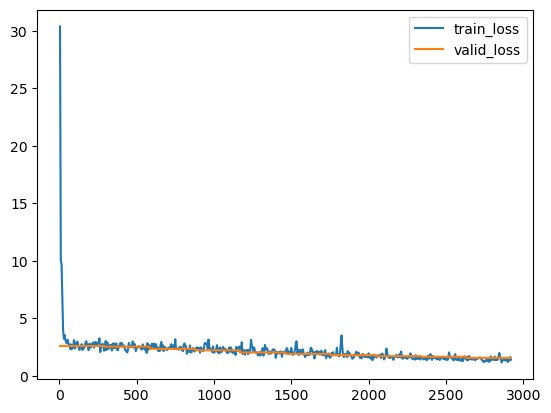

In [26]:
plt.plot(losses['step'], losses['train_loss'], label='train_loss')
plt.plot(losses['step'], losses['valid_loss'], label='valid_loss')
plt.legend()


In [30]:
# Save Model
torch.save({
    'epoch': trainer.current_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
    os.path.join(log_path, latest_log, 'checkpoints', 'epochs={}'.format(trainer.current_epoch))
    )

**Test**

In [3]:
modis_model.eval()
losses = trainer.test(model=modis_model, dataloaders=train_loader)

AttributeError: 'dict' object has no attribute 'eval'

Text(0.5, 1.0, 'Pred')

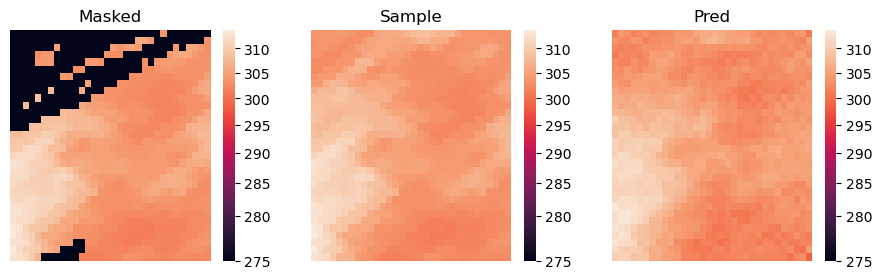

In [29]:
import matplotlib.colors as colors
sample, img = dataset[np.random.randint(len(dataset))]
sample = torch.from_numpy(sample.reshape(1, 1, 32, 32)).type(torch.FloatTensor)
img = torch.from_numpy(img.reshape(1, 1, 32, 32)).type(torch.cuda.FloatTensor)
pred = modis_model.forward(sample)

img, sample = np.array(img.detach().cpu()).reshape(32, 32), np.array(sample.detach().cpu()).reshape(32, 32)
pred = np.array(pred.detach().cpu()).reshape(32, 32)
cmap = sns.color_palette(
    'rocket', as_cmap=True
)
norm = colors.PowerNorm(gamma=0.8, vmin = 275, vmax=np.max(sample))

fig, axs = plt.subplots(1, 3, figsize=(11, 3))
sns.heatmap(sample, ax=axs[0], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[0].set_title('Masked')

sns.heatmap(img, ax=axs[1], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[1].set_title('Sample')

sns.heatmap(pred, ax=axs[2], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[2].set_title('Pred')



**Evaluate from Checkpoint**

In [29]:
exp_name = 'exp10-25'
loss_fn = F.mse_loss
lr = 1*(10**-4)
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
modis_model = ModisNet.load_from_checkpoint('logs/baseline/version_12/checkpoints/epoch=17-step=2970.ckpt',
                                            model=model,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer)
modis_model.eval()

ModisNet(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [30]:
data_root = os.path.join('../../data/set_baseline')
dataset = LSTDataset(
    os.path.join(data_root, 'ground_truth'), 
    os.path.join(data_root, 'ground_truth'),
    os.path.join(data_root, 'collection.csv')
    )


In [35]:
losses = modis_model.test(model=modis_model, dataloaders=train_loader)

AttributeError: 'ModisNet' object has no attribute 'test'

Text(0.5, 1.0, 'Pred')

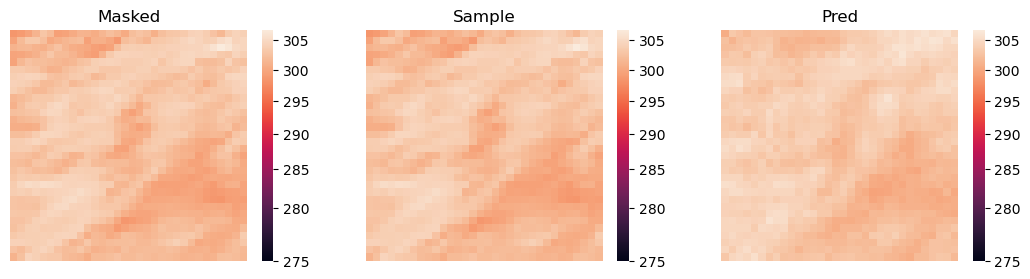

In [33]:
import matplotlib.colors as colors
sample, img = dataset[np.random.randint(len(dataset))]
sample = torch.from_numpy(sample.reshape(1, 1, 32, 32)).type(torch.cuda.FloatTensor)
img = torch.from_numpy(img.reshape(1, 1, 32, 32)).type(torch.cuda.FloatTensor)
pred = modis_model.forward(sample)

img, sample = np.array(img.detach().cpu()).reshape(32, 32), np.array(sample.detach().cpu()).reshape(32, 32)
pred = np.array(pred.detach().cpu()).reshape(32, 32)
cmap = sns.color_palette(
    'rocket', as_cmap=True
)
norm = colors.PowerNorm(gamma=0.8, vmin = 275, vmax=np.max(sample))

fig, axs = plt.subplots(1, 3, figsize=(13, 3))
sns.heatmap(sample, ax=axs[0], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[0].set_title('Masked')

sns.heatmap(img, ax=axs[1], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[1].set_title('Sample')

sns.heatmap(pred, ax=axs[2], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[2].set_title('Pred')
